# Variational Autoencoder for Recommendation

In [1]:
import numpy as np
import pandas as pd
import scipy.sparse
from scipy import sparse
from scipy.sparse import csr_matrix
import math
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import warnings
warnings.filterwarnings('ignore')
import time

# Util Functions for Data preparation

In [6]:
def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id, as_index=False)
    count = playcount_groupbyid.size()
    return count
def filter_triplets(tp, min_uc=0, min_sc=0):
    # Only keep the triplets for items which were rated by at least min_sc users. 
    if min_sc > 0:
        itemcount = get_count(tp, 'movieId')
        tp = tp[tp['movieId'].isin(itemcount.index[itemcount >= min_sc])]
    
    # Only keep the triplets for users who rated at least min_uc items
    # After doing this, some of the items will have less than min_uc users, but should only be a small proportion
    if min_uc > 0:
        usercount = get_count(tp, 'userId')
        tp = tp[tp['userId'].isin(usercount.index[usercount >= min_uc])]
    
    # Update both usercount and itemcount after filtering
    usercount, itemcount = get_count(tp, 'userId'), get_count(tp, 'movieId') 
    return tp, usercount, itemcount

In [8]:
def numerize(tp):
    uid = list(map(lambda x: profile2id[x], tp['userId']))
    sid = list(map(lambda x: show2id[x], tp['movieId']))
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

# Util Functions for Evaluation

In [3]:
def ndcgatk(x_test, x_predict, k):
    ndcg_values = []
    total_ndcg = 0.0
    best  = 0.0
    for i in range(len(x_test)):
        top_rated_movies_idx = [i for i, x in enumerate(x_test[i].tolist()) if x == 1.0]

        if len(top_rated_movies_idx) == 0:
            #print("test user has no 1 rated movies: ", i)
            continue
        sorted_ratings = x_predict[i].tolist()
        top_predicted_movies_idx = sorted(range(len(sorted_ratings)), key=lambda i: sorted_ratings[i])[-k:]
        sum_ndcg = 0
        for i in range(0, k):
            if top_predicted_movies_idx[i] in top_rated_movies_idx:
                ndcg = 1/(math.log(i+2))
            else:
                ndcg = 0
            sum_ndcg += ndcg

        total_ndcg += sum_ndcg
        ndcg_values.append(sum_ndcg)

    ndcg_values = np.array(ndcg_values)
    max_ndcg = ndcg_values.max()
    ndcg_values = ndcg_values / max_ndcg 
    total_ndcg = np.sum(ndcg_values)

    return total_ndcg/float(len(ndcg_values))

In [4]:
def recallatk(x_test, x_predict, k):
    recall_values = []
    total_recall = 0.0
    for i in range(len(x_test)):
        top_rated_movies_idx = [i for i, x in enumerate(x_test[i].tolist()) if x == 1.0]

        if len(top_rated_movies_idx) == 0:
            #print("test user has no 1 rated movies: ", i)
            continue

        sorted_ratings = x_predict[i].tolist()
        top_predicted_movies_idx = sorted(range(len(sorted_ratings)), key=lambda i: sorted_ratings[i])[-k:]

        sum = 0.0
        for i in range(0, k):
            if top_predicted_movies_idx[i] in top_rated_movies_idx:
                sum+=1.0
        recall = sum/float(min(k, len(top_rated_movies_idx)))
        total_recall += recall
        recall_values.append(recall)
    return total_recall/float(len(recall_values))

In [5]:
def catalogcoverage(k,predict_ranks):
    item_count = []
    for uid in list(range(0,predict_ranks.shape[1])):
        recs = predict_ranks.iloc[:,uid:uid+1].nsmallest(k,uid).index
        recs = recs.tolist()
        item_count.append(recs)
    n_items = predict_ranks.shape[0]
    item_count_flat = []
    for sublist in item_count:
        for item in sublist:
            item_count_flat.append(item)
    item_count = list(set(item_count_flat))
    cc = len(item_count)/n_items
    return cc

In [10]:
import numpy as np
import pickle
import os
from keras.layers import Input, Dense, Lambda, merge, Embedding, Flatten, LSTM, Dropout
from keras.models import Model, Sequential
from keras import objectives
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, Callback
import keras
import tensorflow as tf
import pdb
import pandas as pd
from scipy import sparse
import os    
import math

Using TensorFlow backend.


# Load Dataset - Movielens

In [27]:
data = pd.read_table('./ml-10M100K/ratings.dat',sep='::',names=['userId','movieId','rating','time'])
movies = pd.read_table('./ml-10M100K/movies.dat',sep='::',names=['movieId','title','genre'])

## Make Dataset to Implicit Feedback, Take only Rating > 3.5

In [28]:
data = data.drop(['time'],axis=1)
data = data[data['rating'] > 3.5]
data['rating'] = data['rating'].apply(lambda x: 1)
#Take items which only appear over 5times
raw_data, user_activity, item_popularity = filter_triplets(data,min_sc=5)

In [47]:
n_movie = len(pd.unique(raw_data['movieId']))

In [48]:
n_movie

8790

## Create user, movie to dictionary

In [49]:
unique_uid = user_activity.index
unique_sid = pd.unique(raw_data['movieId'])
show2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))

In [50]:
unique_sid

array([  122,   185,   231, ..., 25840,  1908, 53450])

In [54]:
def df_to_sparsematrix(df):    
    start_idx = min(df['uid'].min(), df['uid'].min())
    end_idx = max(df['uid'].max(), df['uid'].max())

    rows_df, cols_df = df['uid'] - start_idx, df['sid']

    data = sparse.csr_matrix((np.ones_like(rows_df),
                             (rows_df, cols_df)), dtype='float64', shape=(end_idx - start_idx + 1, n_movie))
    return data

In [53]:
raw_data_n = numerize(raw_data)

In [55]:
sparse_dataset = df_to_sparsematrix(raw_data_n)

## Sampling Function for Variational Autoencoder

In [56]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Model Definition

In [57]:
original_dim=n_movie
input_shape = (original_dim, )
intermediate_dim = 600
batch_size = 128
latent_dim = 200
epochs = 50


inputs = Input(shape=input_shape)
inputs_d = Dropout(0.5)(inputs)
x = Dense(intermediate_dim, activation='relu')(inputs_d)
x = Dense(400, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(400, activation='relu')(latent_inputs)
x = Dense(intermediate_dim, activation='relu')(x)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

## Loss function - Binry Crossentropy + KLD

In [58]:
from keras.losses import mse, binary_crossentropy
def vae_loss(inputs,outputs):
    reconstruction_loss = binary_crossentropy(inputs, outputs)

    reconstruction_loss *= original_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss) + K.mean(kl_loss)
    return vae_loss

vae.compile(optimizer='adam', loss=vae_loss)

In [59]:
sparse_dataset

<69797x8790 sparse matrix of type '<class 'numpy.float64'>'
	with 5002317 stored elements in Compressed Sparse Row format>

## Start Training

In [60]:
start = time.time()
loss_history = vae.fit(sparse_dataset,sparse_dataset, validation_split=0.2, batch_size=128, epochs = 20)
end = time.time()
vae_tr_time=end-start

Train on 55837 samples, validate on 13960 samples
Epoch 1/20
55837/55837 [==============================] - 21s 370us/step - loss: 340.6261 - val_loss: 265.3916
Epoch 2/20
55837/55837 [==============================] - 19s 349us/step - loss: 250.6877 - val_loss: 243.5393
Epoch 3/20
55837/55837 [==============================] - 19s 349us/step - loss: 233.9956 - val_loss: 234.6319
Epoch 4/20
55837/55837 [==============================] - 19s 348us/step - loss: 225.8950 - val_loss: 225.5740
Epoch 5/20
55837/55837 [==============================] - 19s 349us/step - loss: 219.0414 - val_loss: 220.1718
Epoch 6/20
55837/55837 [==============================] - 19s 349us/step - loss: 215.2828 - val_loss: 217.3724
Epoch 7/20
55837/55837 [==============================] - 20s 350us/step - loss: 212.1641 - val_loss: 213.9131
Epoch 8/20
55837/55837 [==============================] - 19s 348us/step - loss: 209.9762 - val_loss: 212.2358
Epoch 9/20
55837/55837 [==============================] - 20s 

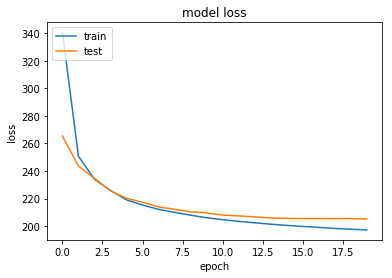

In [61]:
plt.plot(loss_history.history['loss'])
plt.plot(loss_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [62]:
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 8790)              0         
_________________________________________________________________
encoder (Model)              [(None, 200), (None, 200) 5675400   
_________________________________________________________________
decoder (Model)              (None, 8790)              5603790   
Total params: 11,279,190
Trainable params: 11,279,190
Non-trainable params: 0
_________________________________________________________________


## Recommendation Result

In [63]:
raw_data_meta = pd.merge(raw_data,movies, how='left')

## Create Prediction Matrix

In [64]:
start = time.time()
x_test_reconstructed = vae.predict(sparse_dataset)
end = time.time()
vae_te_time = end-start

In [65]:
x_test_reconstructed.shape

(69797, 8790)

## Prediction for User#768

In [85]:
temp = x_test_reconstructed[854]

In [86]:
score_list = []
cnt = 0
for i in temp:
    score_list.append((cnt,i))
    cnt = cnt+1

In [87]:
score_list = sorted(score_list, key = lambda x: x[1], reverse=True)

In [88]:
movie_sorted_list = []
for i in score_list:
    movie_sorted_list.append(unique_sid[i[0]])

## History for User#854

In [89]:
raw_data_meta.loc[raw_data_meta['userId']==unique_uid[854]]

,userId,movieId,rating,title,genre
61852,901,318,1,"Shawshank Redemption, The (1994)",Drama
61853,901,457,1,"Fugitive, The (1993)",Thriller
61854,901,589,1,Terminator 2: Judgment Day (1991),Action|Sci-Fi
61855,901,832,1,Ransom (1996),Action|Crime|Drama|Thriller
61856,901,858,1,"Godfather, The (1972)",Crime|Drama
61857,901,902,1,Breakfast at Tiffany's (1961),Drama|Romance
61858,901,1036,1,Die Hard (1988),Action|Crime|Thriller
61859,901,1197,1,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance
61860,901,1200,1,Aliens (1986),Action|Horror|Sci-Fi|Thriller
61861,901,1201,1,"Good, the Bad and the Ugly, The (Buono, il bru...",Action|Adventure|Western


In [91]:
history_list = raw_data_meta.loc[raw_data_meta['userId']==unique_uid[854]]['movieId']

In [92]:
history_items=[]
for i in history_list:
    history_items.append(i)

In [93]:
temp_df = movies[movies['movieId'].isin(movie_sorted_list)]
temp_df['sort_cat'] = pd.Categorical(temp_df['movieId'], categories=movie_sorted_list, ordered=True)
temp_df.sort_values('sort_cat', inplace=True)
temp_df.reset_index(inplace=True)
temp_df[~temp_df['movieId'].isin(history_items)]
#temp_df

,index,movieId,title,genre,sort_cat
0,1173,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,1198
1,257,260,Star Wars: Episode IV - A New Hope (a.k.a. Sta...,Action|Adventure|Sci-Fi,260
2,1171,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,1196
4,1184,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,1210
6,1944,2028,Saving Private Ryan (1998),Action|Drama|War,2028
7,587,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,593
8,108,110,Braveheart (1995),Action|Drama|War,110
13,1195,1221,"Godfather: Part II, The (1974)",Crime|Drama,1221
17,523,527,Schindler's List (1993),Drama|War,527
18,1263,1291,Indiana Jones and the Last Crusade (1989),Action|Adventure,1291
